In [1]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from bs4 import BeautifulSoup
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

%matplotlib inline
import os

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
## Quick look at the train
train.head()

qa_id                                     question_title  \
0      0  What am I losing when using extension tubes in...   
1      1  What is the distinction between a city and a s...   
2      2  Maximum protusion length for through-hole comp...   
3      3              Can an affidavit be used in Beit Din?   
4      5       How do you make a binary image in Photoshop?   

                                       question_body question_user_name  \
0  After playing around with macro photography on...               ysap   
1  I am trying to understand what kinds of places...      russellpierce   
2  I'm working on a PCB that has through-hole com...          Joe Baker   
3  An affidavit, from what i understand, is basic...         Scimonster   
4  I am trying to make a binary image. I want mor...            leigero   

                                  question_user_page  \
0         https://photo.stackexchange.com/users/1024   
1           https://rpg.stackexchange.com/users/8774   
2  https://electronics.stackexchange.com/users/10157   
3       https://judaism.stackexchange.com/users/5151   
4  https://graphicdesign.stackexchange.com/users/...   

                                              answer answer_user_name  \
0  I just got extension tubes, so here's the skin...           rfusca   
1  It might be helpful to look into the definitio...     Erik Schmidt   
2  Do you even need grooves?  We make several pro...      Dwayne Reid   
3  Sending an "affidavit" it is a dispute between...    Y     e     z   
4  Check out Image Trace in Adobe Illustrator. \n...             q2ra   

                                    answer_user_page  \
0         https://photo.stackexchange.com/users/1917   
1           https://rpg.stackexchange.com/users/1871   
2  https://electronics.stackexchange.com/users/64754   
3       https://judaism.stackexchange.com/users/4794   
4  https://graphicdesign.stackexchange.com/users/...   

                                                 url   category  ...  \
0  http://photo.stackexchange.com/questions/9169/...  LIFE_ARTS  ...   
1  http://rpg.stackexchange.com/questions/47820/w...    CULTURE  ...   
2  http://electronics.stackexchange.com/questions...    SCIENCE  ...   
3  http://judaism.stackexchange.com/questions/551...    CULTURE  ...   
4  http://graphicdesign.stackexchange.com/questio...  LIFE_ARTS  ...   

  question_well_written  answer_helpful  answer_level_of_information  \
0              1.000000        1.000000                     0.666667   
1              0.888889        0.888889                     0.555556   
2              0.777778        0.777778                     0.555556   
3              0.888889        0.833333                     0.333333   
4              1.000000        1.000000                     0.666667   

   answer_plausible  answer_relevance  answer_satisfaction  \
0          1.000000          1.000000             0.800000   
1          0.888889          0.888889             0.666667   
2          1.000000          1.000000             0.666667   
3          0.833333          1.000000             0.800000   
4          1.000000          1.000000             0.800000   

   answer_type_instructions  answer_type_procedure  \
0                       1.0               0.000000   
1                       0.0               0.000000   
2                       0.0               0.333333   
3                       0.0               0.000000   
4                       1.0               0.000000   

   answer_type_reason_explanation  answer_well_written  
0                        0.000000             1.000000  
1                        0.666667             0.888889  
2                        1.000000             0.888889  
3                        1.000000             1.000000  
4                        1.000000             1.000000  

[5 rows x 41 columns]

In [4]:
#Quick look at the test 
test.head()

qa_id                                     question_title  \
0     39  Will leaving corpses lying around upset my pri...   
1     46         Url link to feature image in the portfolio   
2     70  Is accuracy, recoil or bullet spread affected ...   
3    132     Suddenly got an I/O error from my external HDD   
4    200  Passenger Name - Flight Booking Passenger only...   

                                       question_body question_user_name  \
0  I see questions/information online about how t...              Dylan   
1  I am new to Wordpress. i have issue with Featu...                Anu   
2  To experiment I started a bot game, toggled in...             Konsta   
3  I have used my Raspberry Pi as a torrent-serve...           robbannn   
4  I have bought Delhi-London return flights for ...               Amit   

                                  question_user_page  \
0       https://gaming.stackexchange.com/users/64471   
1    https://wordpress.stackexchange.com/users/72927   
2       https://gaming.stackexchange.com/users/37545   
3  https://raspberrypi.stackexchange.com/users/17341   
4       https://travel.stackexchange.com/users/29089   

                                              answer answer_user_name  \
0  There is no consequence for leaving corpses an...        Nelson868   
1  I think it is possible with custom fields.\n\n...            Irina   
2  You do not have armour in the screenshots. Thi...   Damon Smithies   
3  Your Western Digital hard drive is disappearin...      HeatfanJohn   
4  I called two persons who work for Saudia (tick...    Nean Der Thal   

                                   answer_user_page  \
0      https://gaming.stackexchange.com/users/97324   
1   https://wordpress.stackexchange.com/users/27233   
2      https://gaming.stackexchange.com/users/70641   
3  https://raspberrypi.stackexchange.com/users/1311   
4      https://travel.stackexchange.com/users/10051   

                                                 url    category  \
0  http://gaming.stackexchange.com/questions/1979...     CULTURE   
1  http://wordpress.stackexchange.com/questions/1...  TECHNOLOGY   
2  http://gaming.stackexchange.com/questions/2154...     CULTURE   
3  http://raspberrypi.stackexchange.com/questions...  TECHNOLOGY   
4  http://travel.stackexchange.com/questions/4704...     CULTURE   

                            host  
0       gaming.stackexchange.com  
1    wordpress.stackexchange.com  
2       gaming.stackexchange.com  
3  raspberrypi.stackexchange.com  
4       travel.stackexchange.com

In [5]:
print('Train Shape: {}, Test Shape: {}'.format(train.shape, test.shape))

Train Shape: (6079, 41), Test Shape: (476, 11)


In [6]:
train.host.nunique()

63

In [14]:
## Count the missing values 
miss_val_train = train.isnull().sum(axis=0) / len(train)
miss_val_train
#No missing values in train dataset

qa_id                                    0.0
question_title                           0.0
question_body                            0.0
question_user_name                       0.0
question_user_page                       0.0
answer                                   0.0
answer_user_name                         0.0
answer_user_page                         0.0
url                                      0.0
category                                 0.0
host                                     0.0
question_asker_intent_understanding      0.0
question_body_critical                   0.0
question_conversational                  0.0
question_expect_short_answer             0.0
question_fact_seeking                    0.0
question_has_commonly_accepted_answer    0.0
question_interestingness_others          0.0
question_interestingness_self            0.0
question_multi_intent                    0.0
question_not_really_a_question           0.0
question_opinion_seeking                 0.0
question_t

In [16]:
## Number of train columns
len(list(train.columns))
#Contains 41 columns, out of which 30 are labels containing ratings for question and answer pair

41

In [90]:
#number of unique users
print('Number of unique users who asked questions :', train.question_user_page.nunique())
print('Number of unique users who answered questions :', train.answer_user_page.nunique())

Number of unique users who asked questions : 3422
Number of unique users who answered questions : 4430


In [7]:
## Check the scoring for questions
train_col = list(train.columns)
qa_input_cols = train_col[:11]
q_target_cols = train_col[11:32]
a_target_cols  = train_col[32:41]

In [8]:
## Check one question and answer  
question_t_sample = train['question_title'][951]
question_b_sample = train['question_body'][951]
answer_sample = train['answer'][951]

print("Sample Question Topic: {}\n\n".format(question_t_sample))
print("Sample Question Body : {}\n\n".format(question_b_sample))
print("Sample answer :{}".format(answer_sample))

Sample Question Topic: Negatively curved metrics minimizing the length of a homotopy class of simple closed curves


Sample Question Body : Good afternoon everyone !

I have the following question of Riemannian geometry :

Let $M$ be a smooth closed orientable manifold of dimension at least $3$, and let $\mathcal{T} = \{ $ smooth Riemannian metric on $M$ with sectional curvature pinched between $-1- \epsilon$ and $-1$ $\}$ where $\epsilon$ is an arbitrary positive number. Assume that $\mathcal{T}$ is non-empty.

Let $\gamma $ be a simple closed curve in $M$. It is classical that for every negatively curved metric $g$ there is a unique closed curve in the free homotopy class of $\gamma$ that is length minimizing. Note $L_g(\gamma)$ the length of such a curve.

1) Is it known whether $ \inf_{g \in \mathcal{T} }{L_g(\gamma)}$ is positive or zero ?

2) Is it known whether $ \sup_{g \in \mathcal{T} }{L_g(\gamma)}$ is finite or infinite ? 

3) Can one say more in specific cases, say when $M$

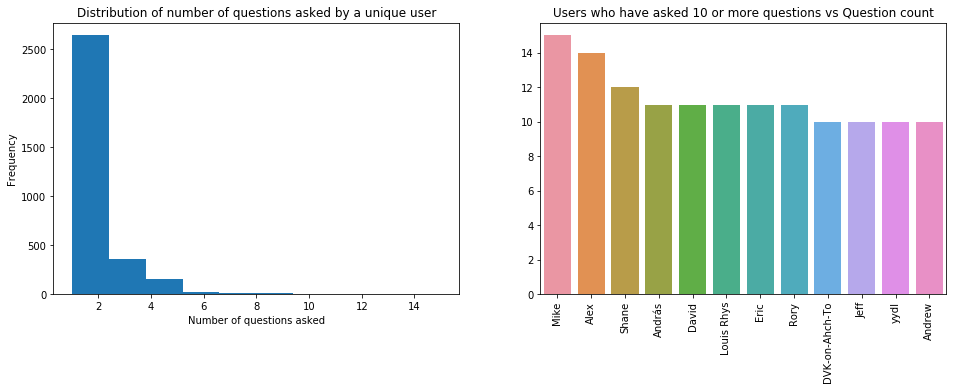

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ques_user = train.question_user_name.value_counts()
ques_user.plot(kind = 'hist', ax = ax1)
ax1.set_title('Distribution of number of questions asked by a unique user')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Number of questions asked')

## Distinct users who have asked 10 or more questions
sns.barplot(x = ques_user.loc[ques_user>=10].index, y = ques_user.loc[ques_user>=10].values, ax = ax2)
plt.xticks(rotation=90)
ax2.set_title('Users who have asked 10 or more questions vs Question count')
plt.show()

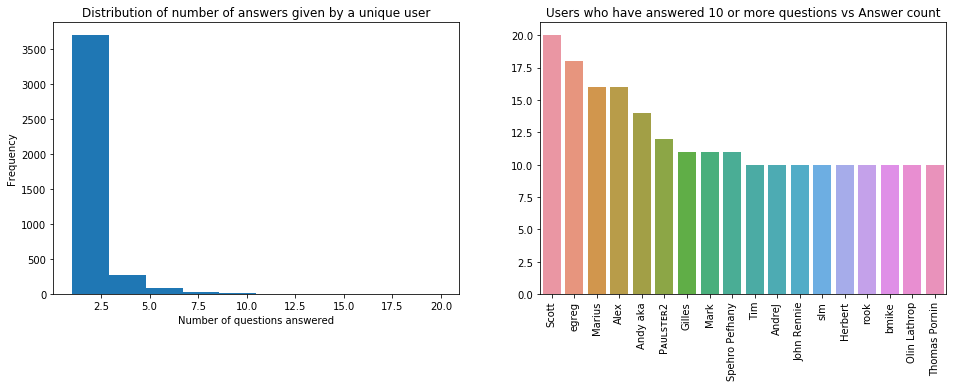

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ans_user = train.answer_user_name.value_counts()
ans_user.plot(kind = 'hist', ax = ax1)
ax1.set_title('Distribution of number of answers given by a unique user')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Number of questions answered')

## Distinct users who have given 10 or more answers
sns.barplot(x = ans_user.loc[ans_user>=10].index, y = ans_user.loc[ans_user>=10].values, ax = ax2)
plt.xticks(rotation=90)
ax2.set_title('Users who have answered 10 or more questions vs Answer count')
plt.show()

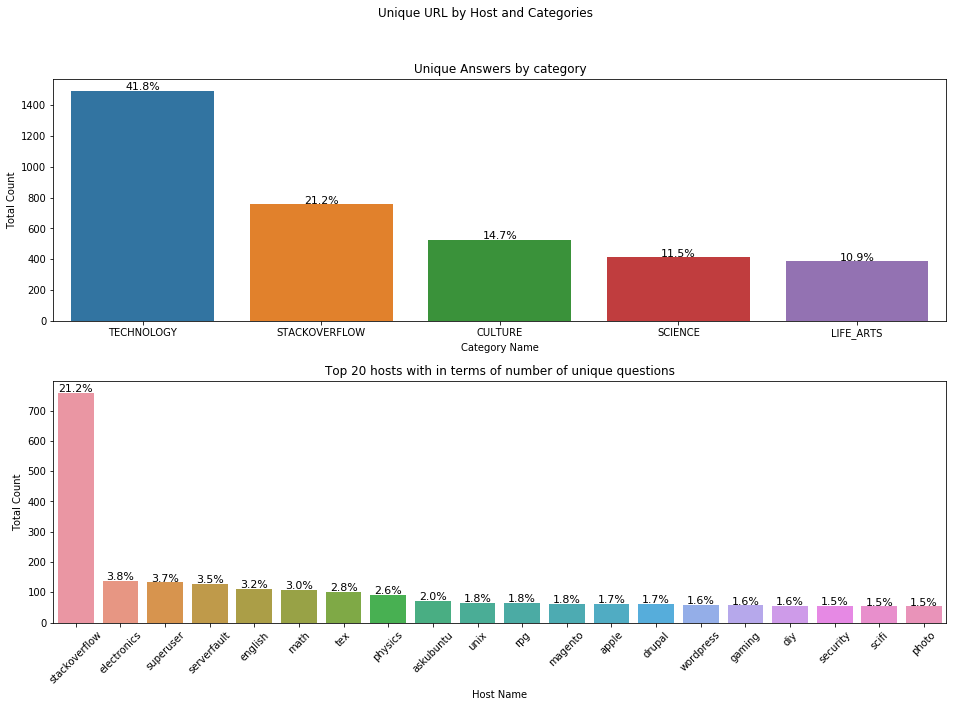

In [6]:
#Getting the host category
train['host_cat'] = train.host.apply(lambda x:x.split('.')[0])
train.drop('host', axis=1, inplace=True)

host = train.groupby(['host_cat'])['url'].nunique().sort_values(ascending=False)
category = train.groupby(['category'])['url'].nunique().sort_values(ascending=False)

plt.figure(figsize=(16,10))
plt.suptitle('Unique URL by Host and Categories')

#https://www.kaggle.com/kabure/qa-eda-and-nlp-modelling-insights-vis-bert
plt.subplot(211)
g0 = sns.barplot(x=category.index, y=category.values)
g0.set_title("Unique Answers by category")
g0.set_xlabel("Category Name")
g0.set_ylabel("Total Count")
for p in g0.patches:
    height = p.get_height()
    g0.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/category.sum()*100),
            ha="center",fontsize=11) 

plt.subplot(212)
g1 = sns.barplot(x=host[:20].index, y=host[:20].values)
g1.set_title("Top 20 hosts with in terms of number of unique questions")
g1.set_xlabel("Host Name")
g1.set_ylabel("Total Count")
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/host.sum()*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.25)

plt.show()

1. In this data maximum questions belong to Technology and Stackoverflow category.
2. At host level the Stackoverflow has considerably more number of questions than any other host category.

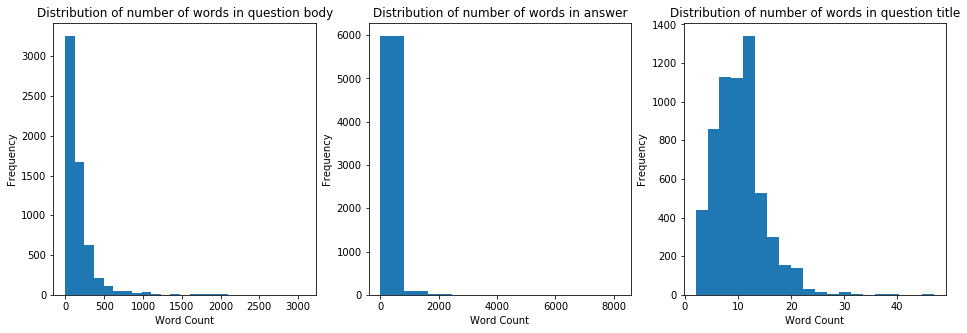

In [4]:
def word_tokens_length(text):
# Tokenize each item in the review column
    word_tokens = word_tokenize(text)
    return len(word_tokens)

# Create a new feature for the lengh of each review
train['question_n_words'] = train.question_body.apply(word_tokens_length)
train['answer_n_words'] = train.answer.apply(word_tokens_length)
train['questitle_n_words'] = train.question_title.apply(word_tokens_length)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,5))

ax1.hist(train['question_n_words'], bins = 25)
ax1.set_title('Distribution of number of words in question body')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Word Count')
ax2.hist(train['answer_n_words'])
ax2.set_title('Distribution of number of words in answer')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Word Count')
ax3.hist(train['questitle_n_words'], bins = 20)
ax3.set_title('Distribution of number of words in question title')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Word Count')
plt.show()

In [23]:
print('99 percentile of question body word count : {:.2f}'.format(np.quantile(train['question_n_words'], 0.99)))
print('99 percentile of answer word counts : {:.2f}'.format(np.quantile(train['answer_n_words'], 0.99)))
print('99 percentile of question title word counts : {:.2f}'.format(np.quantile(train['questitle_n_words'],0.99)))

99 percentile of question body word count : 1043.22
99 percentile of answer word counts : 993.44
99 percentile of question title word counts : 23.22


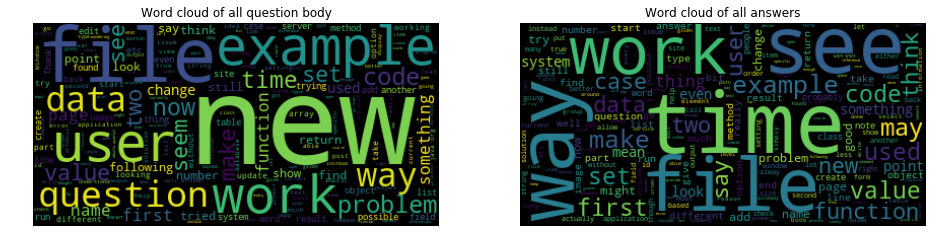

In [86]:
from bs4 import BeautifulSoup
stopwords = set(STOPWORDS)
## Word cloud of question bodies##
stopwords.update(["gt", "lt", "amp", "nbsp", "one", "use", "will","using", "would","need", "want", "know"])
text = ' '.join(BeautifulSoup(txt).get_text() for txt in train.question_body)
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords).generate(text)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word cloud of all question body')

##Word cloud for answers##
text = ' '.join(BeautifulSoup(txt).get_text() for txt in train.answer)

wordcloud = WordCloud(stopwords=stopwords).generate(text):
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word cloud of all answers')

plt.show()

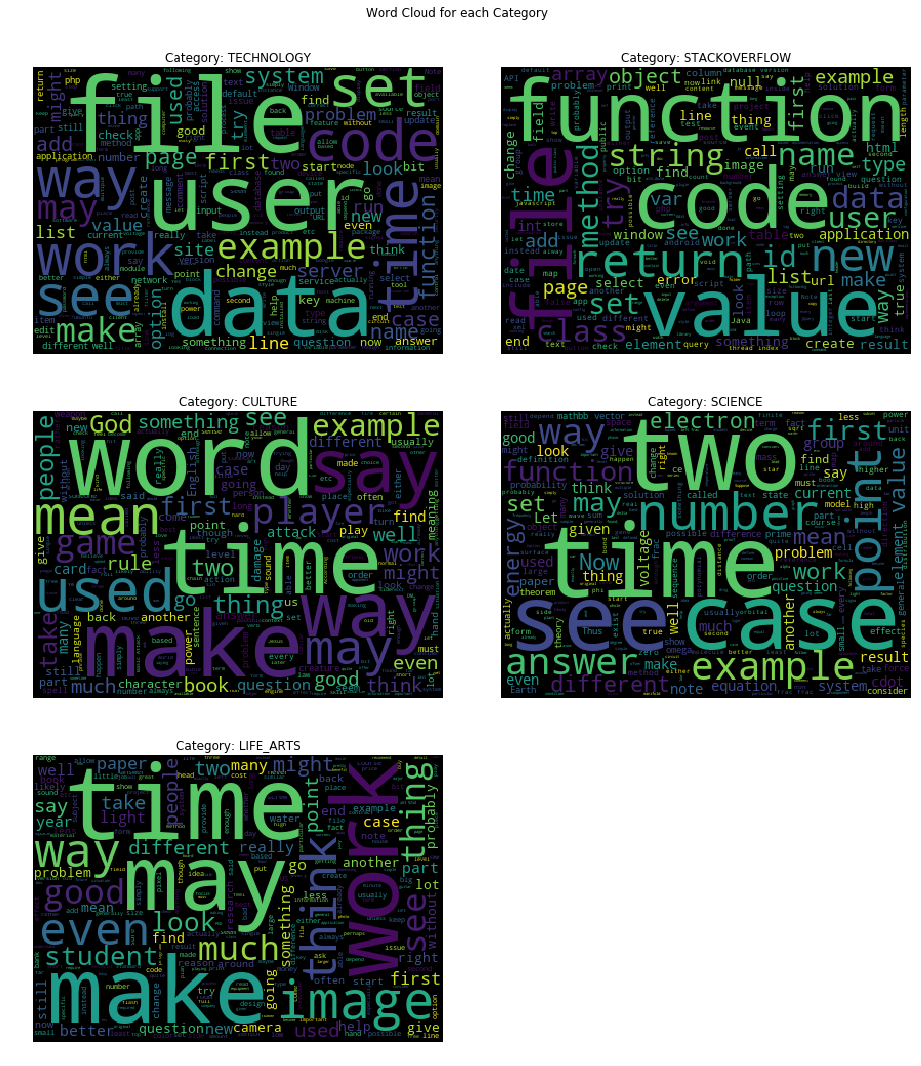

In [87]:
grid = gridspec.GridSpec(5, 2)

plt.figure(figsize=(16,28))

plt.suptitle('Word Cloud for each Category')

for n, col in enumerate(train['category'].value_counts().index):
    ax = plt.subplot(grid[n])  
    text = ' '.join(train[train['category'] == col]['answer'].astype(str))
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=250,
        max_font_size=100, 
        width=400, height=280,
        random_state=42,
    ).generate(text)

    plt.imshow(wordcloud)
    plt.title("Category: {}".format(col))
    plt.axis('off')
plt.subplots_adjust(top = 0.95, hspace=.2, wspace=.1 )

plt.show()

The words in the word cloud for each category reveals the most frequently used words in that field.

- For example code, function, return, value. etc are the most frequently words in category stackoverflow. Similarly for other categories the most frequent words makes sense.

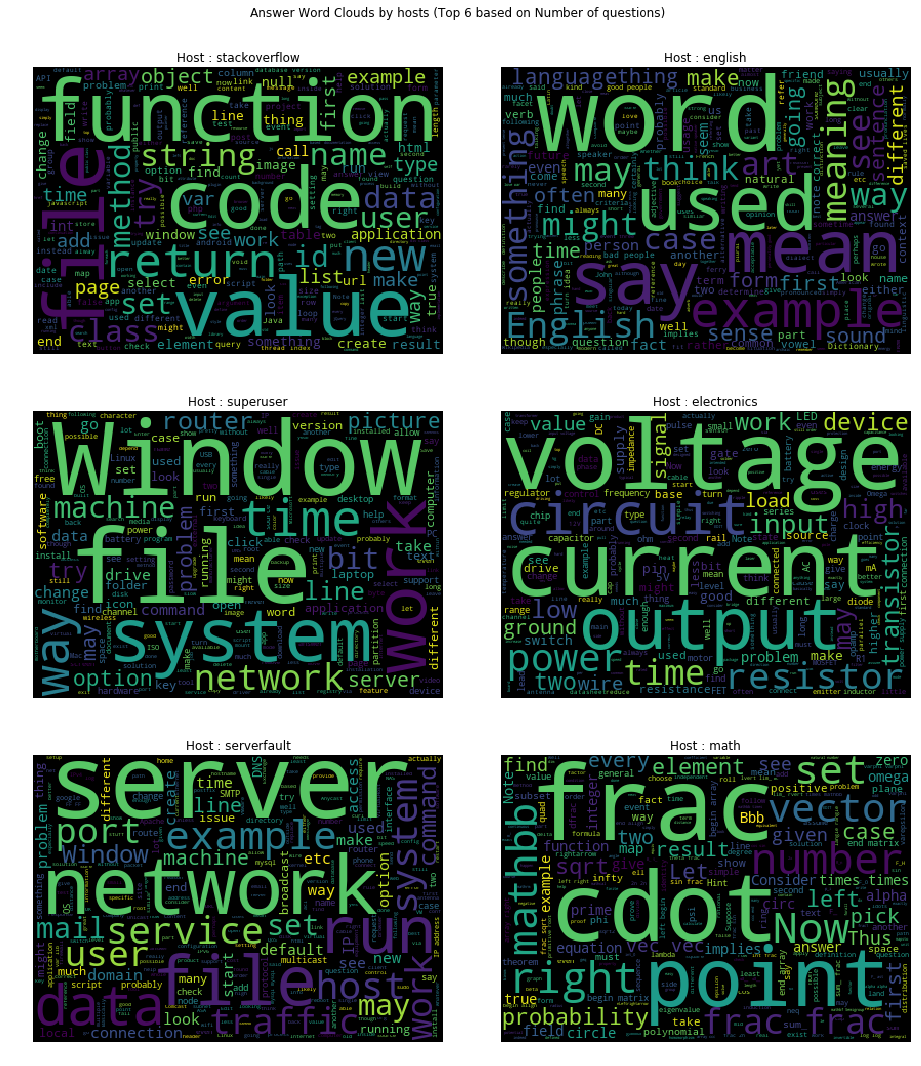

In [88]:
grid = gridspec.GridSpec(5, 2)

plt.figure(figsize=(16,28))

plt.suptitle('Answer Word Clouds by hosts (Top 6 based on Number of questions)')

for n, col in enumerate(train['host_cat'].value_counts()[:6].index):
    text = " ".join(train[train['host_cat'] == col]['answer'].astype(str))
    ax = plt.subplot(grid[n])   
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=250,
        max_font_size=100, 
        width=400, height=280,
        random_state=42,
    ).generate(text)

    plt.imshow(wordcloud)
    plt.title("Host : {}".format(col))
    plt.axis('off')
    
plt.subplots_adjust(top = 0.95, hspace=0.2, wspace=0.1 )

plt.show()

<h4>Some Observations</h4>

- Based on the host or website where the question was answered, the most frequent words used in answers for a given host is chosen.
    - For example electronics has voltage, current, circuit are the most frequent words while for math frac, vector, point are some of the most commonly used words

In [56]:
sid = SentimentIntensityAnalyzer()
def polarity_score_custom(x):
    '''Returns the polarity scores for any document'''
    ss = sid.polarity_scores(x)
    return ss['neg'],ss['neu'],ss['pos'],ss['compound']

#https://stackoverflow.com/questions/16236684/apply-pandas-function-to-column-to-create-multiple-new-columns
train['ques_neg'], train['ques_neu'], train['ques_pos'], train['ques_compound']=\
zip(*train.question_body.map(polarity_score_custom))

train['answer_neg'], train['answer_neu'], train['answer_pos'], train['answer_compound']=\
    zip(*train.answer.map(polarity_score_custom))

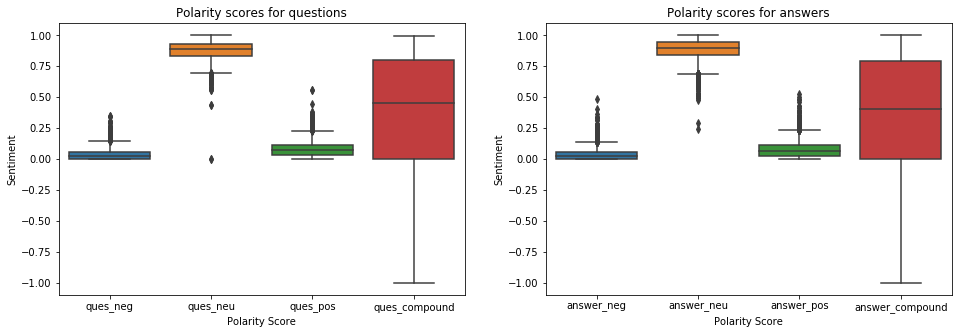

In [60]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
pol_df_q = train[['ques_neg','ques_neu', 'ques_pos', 'ques_compound']]
pol_df_a = train[['answer_neg', 'answer_neu', 'answer_pos','answer_compound']]
sns.boxplot(x="variable", y="value", data=pd.melt(pol_df_q), ax= ax1)
ax1.set_title('Polarity scores for questions')
ax1.set_xlabel('Polarity Score')
ax1.set_ylabel('Sentiment')
sns.boxplot(x="variable", y="value", data=pd.melt(pol_df_a), ax= ax2)
ax2.set_title('Polarity scores for answers')
ax2.set_xlabel('Polarity Score')
ax2.set_ylabel('Sentiment')
plt.show()

- Both the questions and answer have similar polarity distributions.
- Questions and answers are mostly neutral because the websites from which they have been collected are mostly technical in nature, i.e., users do not show much emotion while asking questions or answering.

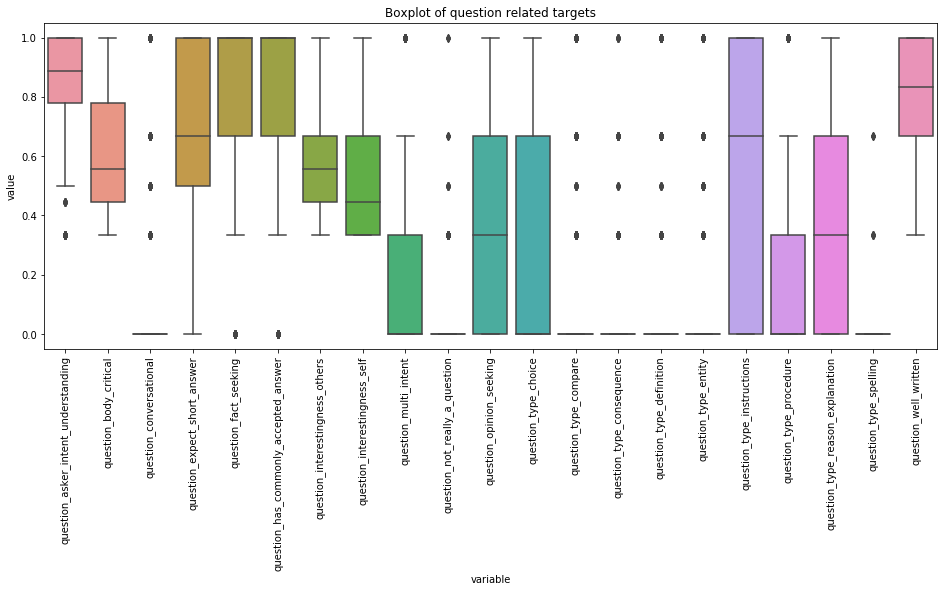

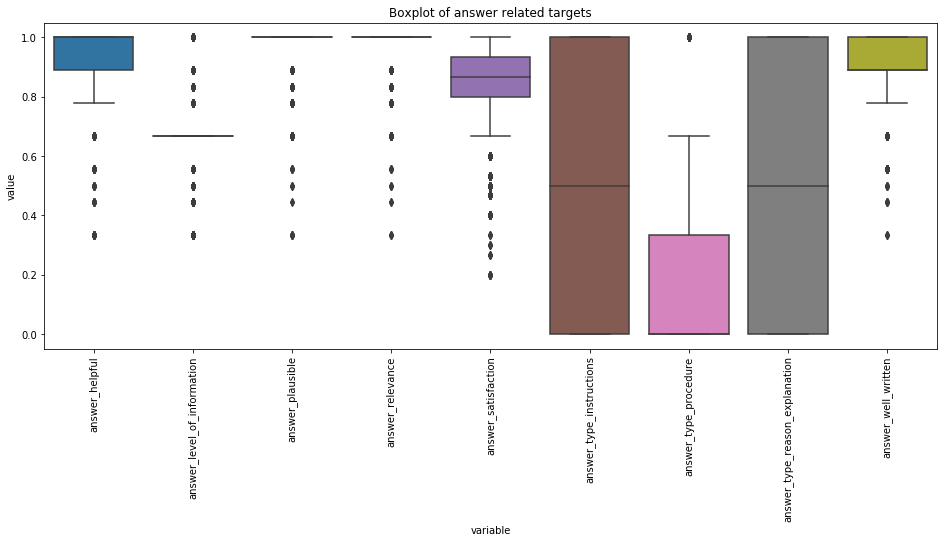

In [5]:
target_dist_q = train[q_target_cols]
target_dist_a = train[a_target_cols]
plt.figure(figsize=(16,6))
sns.boxplot(x="variable", y="value", data=pd.melt(target_dist_q))
plt.xticks(rotation = 'vertical')
plt.title('Boxplot of question related targets')
plt.figure(figsize=(16,6))
sns.boxplot(x="variable", y="value", data=pd.melt(target_dist_a))
plt.xticks(rotation = 'vertical')
plt.title('Boxplot of answer related targets')
plt.show()

<h4>Some Observations</h4>

- Some of the labels like question type definaition question type consequence, question conversational, etc. in general have very low rating barring a few outliers.
- question askers intent understanding and question interestingness others have smallest range of values.
- Most of the answers are well written and are heplful,satisfactory and plausible as indicated by very high median values.

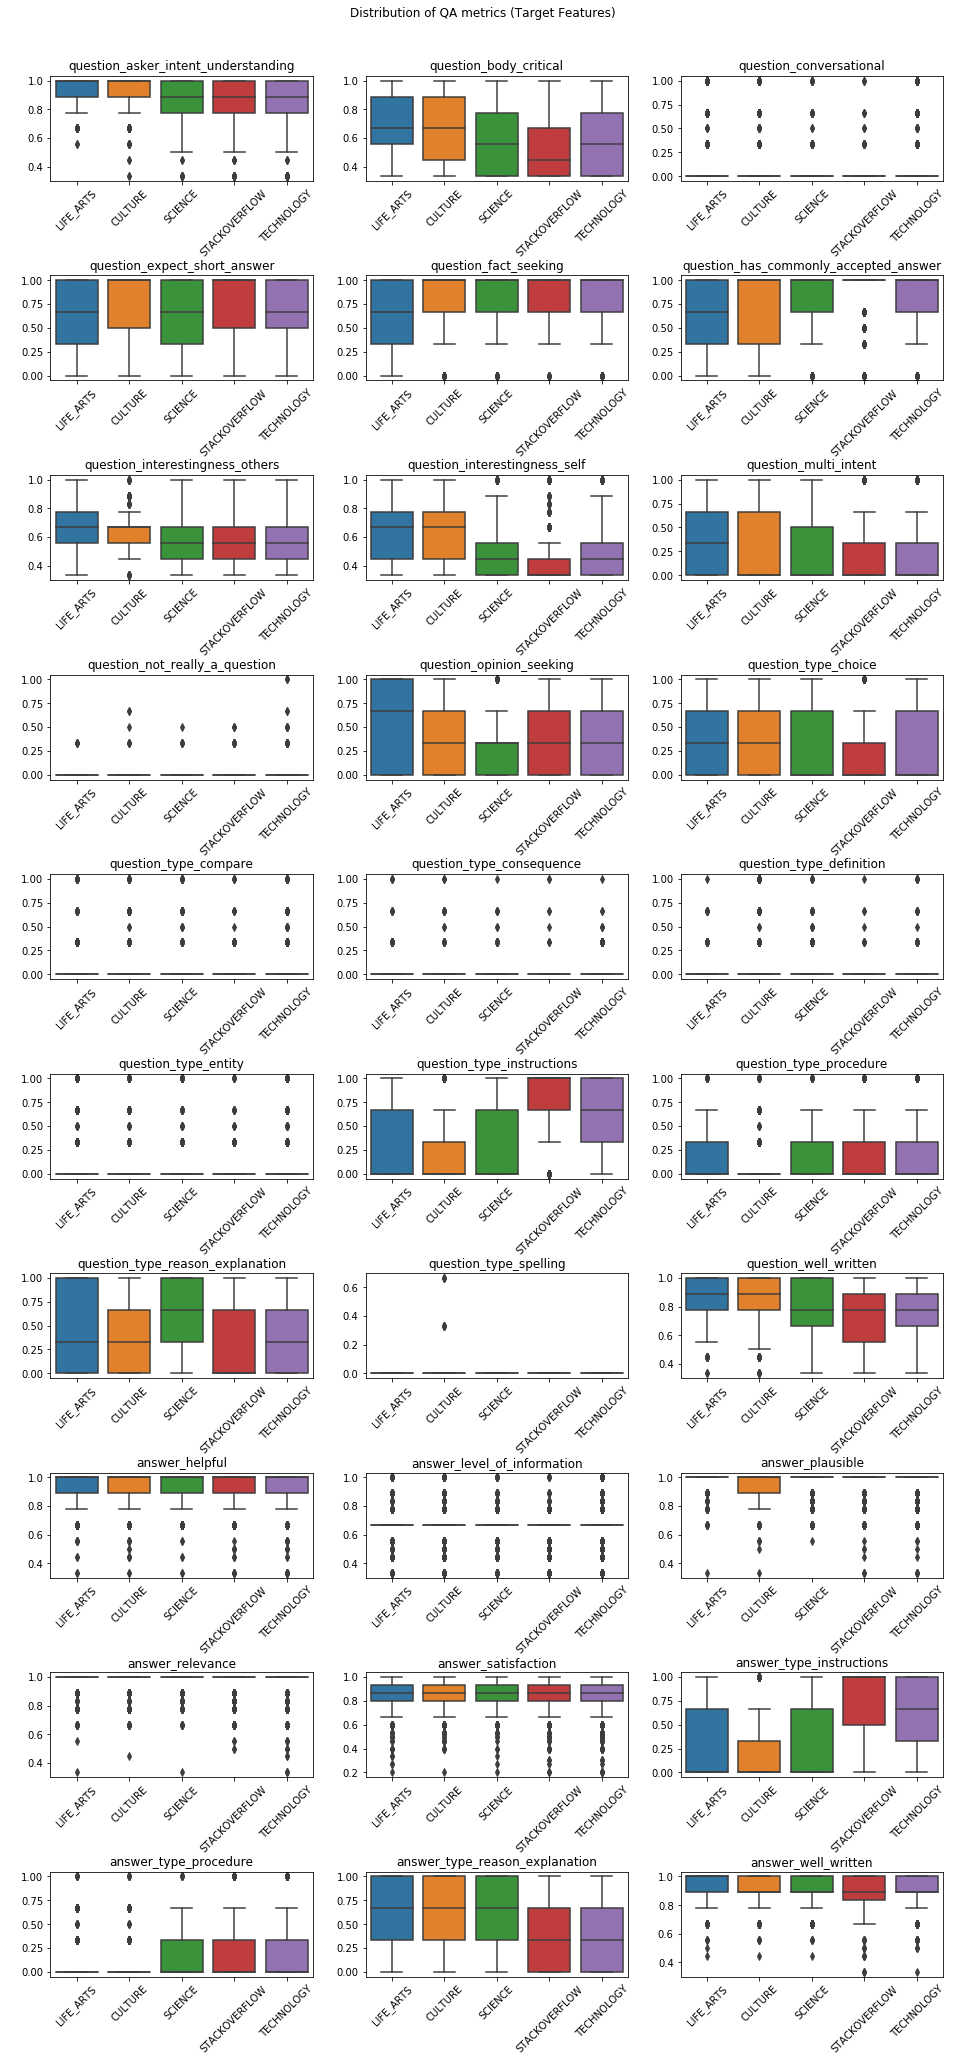

In [50]:
grid = gridspec.GridSpec(10, 3)

plt.figure(figsize=(16,32))
count=0
target_cols = train.columns[10:40]
plt.suptitle('Distribution of QA metrics (Target Features)')
for n, col in enumerate(target_cols):
    ax = plt.subplot(grid[count])
    sns.boxplot(x='category', y=col, data=train)
    ax.set_title(str(col))
    ax.set_xlabel('')
    ax.set_ylabel(' ')
    count+=1
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.2)
plt.show()

<h4>Some Observations</h4>

- The 'category' feature could be an important feature in determining the ratings for these labels:
    - 'answer_type_reason_explanation', 'answer_type_instructions', 'question_well_written', 'question_type_instruction',<br>'question_interestingness_self', 'question_body_critical'
- 'answer_type_instructions' shows that Life Arts, Culture and Science has lower ratings than other categories. 
- For most of the labels the the scores are identical for all categories.

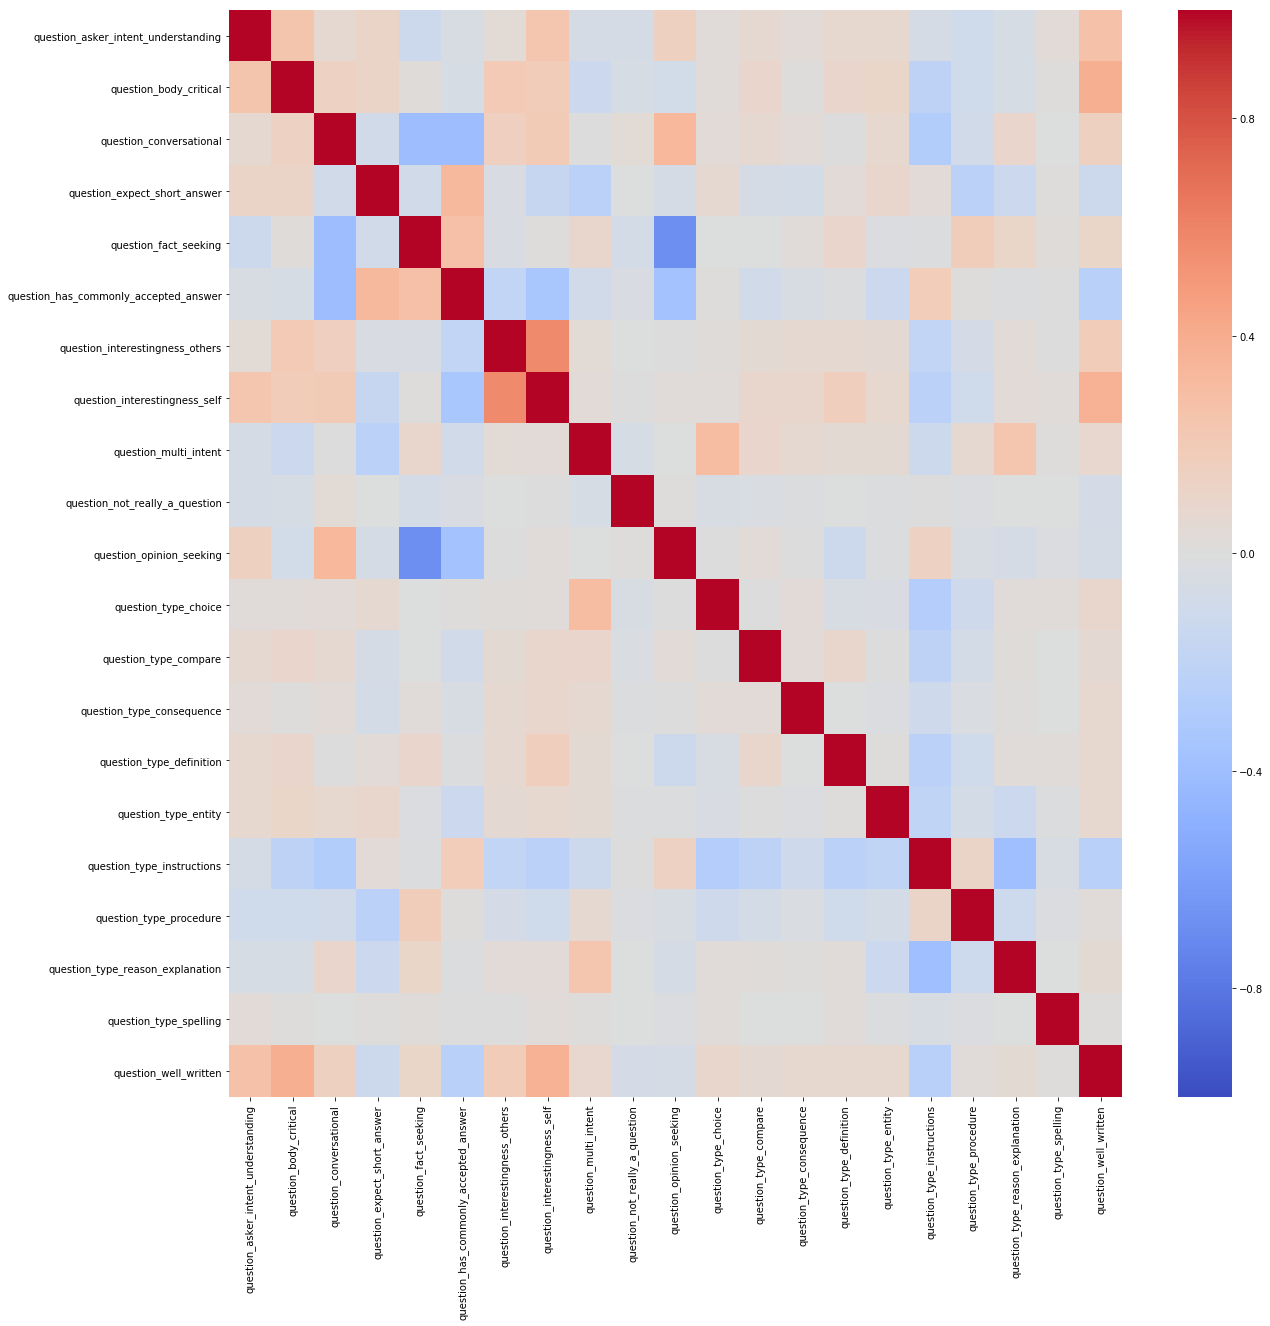

In [10]:
#Correlation amongst the question related targets
plt.figure(figsize=(20,20))
sns.heatmap(train[q_target_cols].corr(),vmin=-1,cmap='coolwarm')
plt.show()

<h4>Observations</h4>

- Question conversational and question opinion seeking has high correlation which is very expected.
- Question has commonly accepted answer and question fact seeking also has some correlation.
- Question interestingness self and others are also correlated.
- Question fact seeking and opinion seeking has high negative correlation.
- For well written questions the question body is critical to some extent.

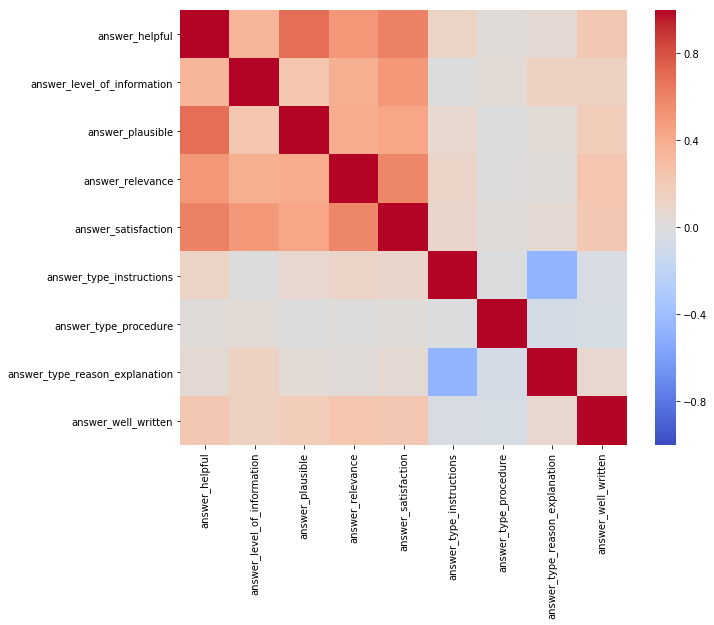

In [15]:
#Correlation amongst the answer related targets
plt.figure(figsize=(10,8))
sns.heatmap(train[a_target_cols].corr(),vmin=-1,cmap='coolwarm')
plt.show()

<h4>Observations</h4>

- Answer helpful, level of information, plausible, relevance and satisfaction has some level of correlation amongst them.
- Answer type instructions and Answer type reason explanation is negatively correlated.

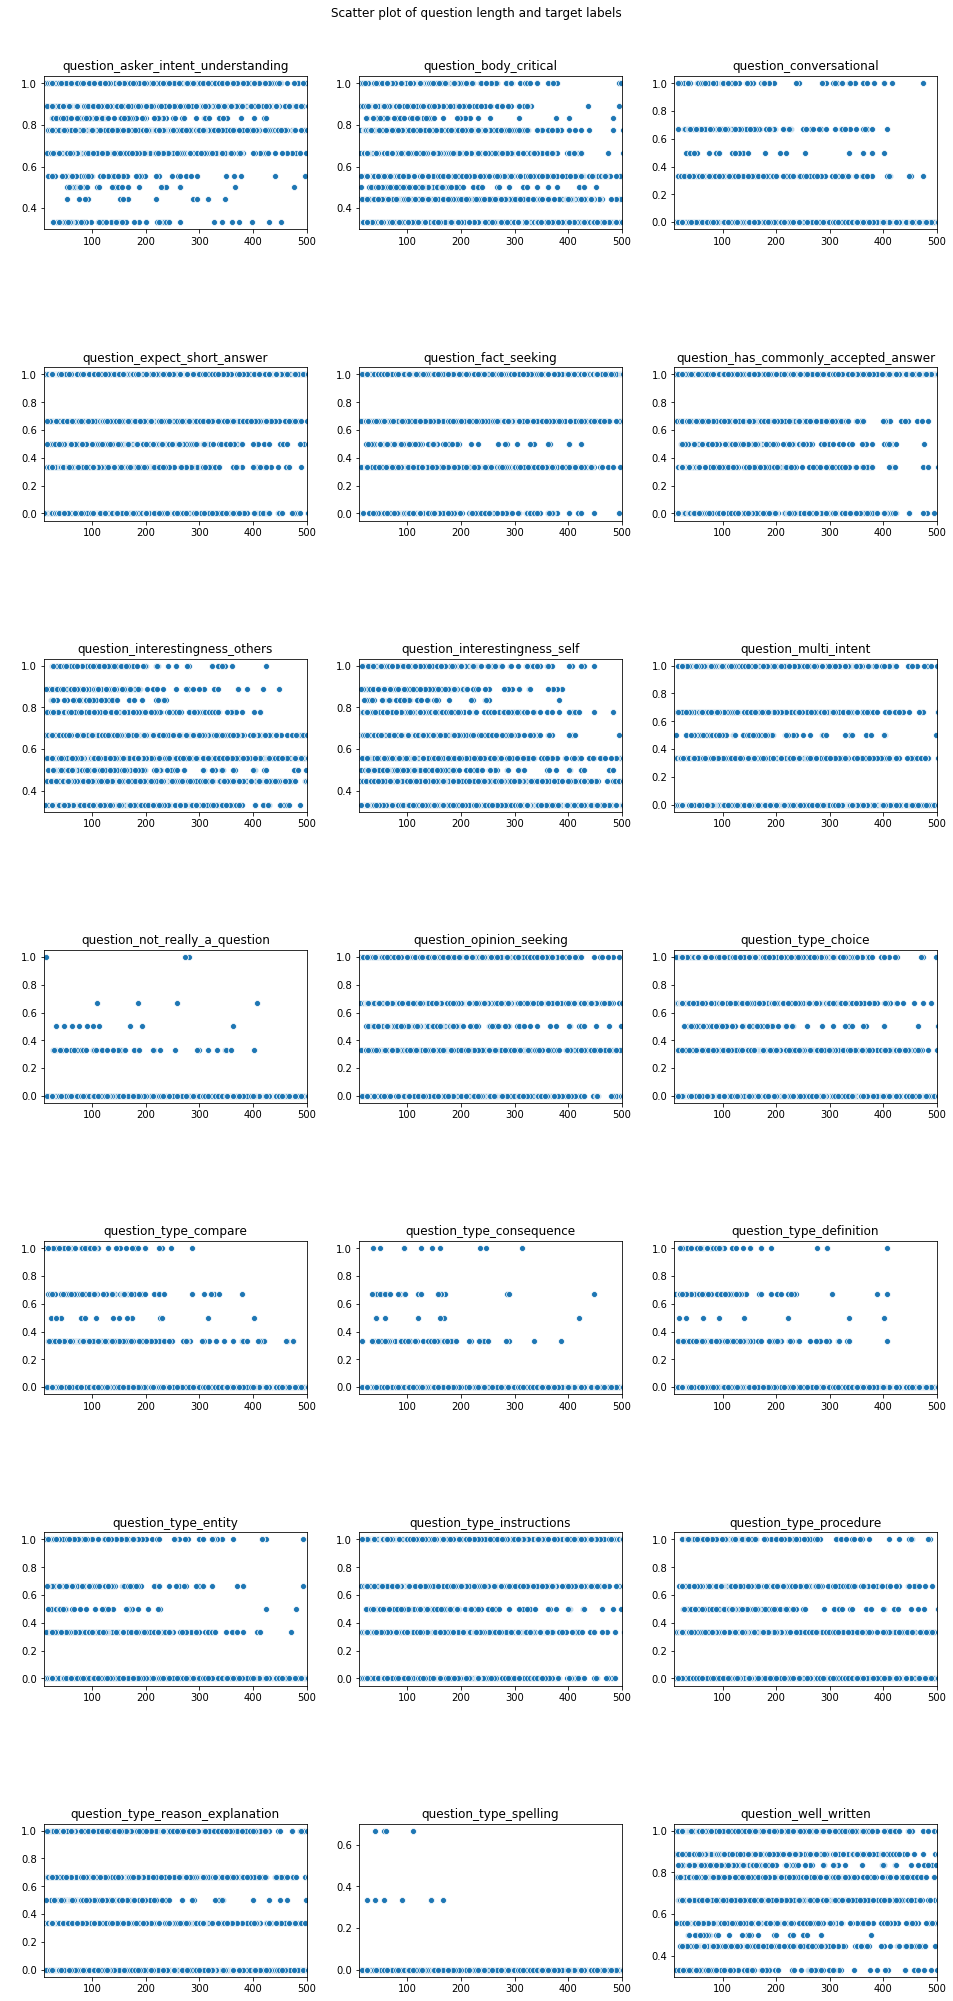

In [105]:
#Checking the relationship of question length with question related labels
grid = gridspec.GridSpec(7,3)

plt.figure(figsize=(16,32))
count=0
target_cols = train[q_target_cols]
plt.suptitle('Scatter plot of question length and target labels')
for n, col in enumerate(target_cols):
    ax = plt.subplot(grid[count])
    sns.scatterplot(x=train.question_n_words, y=train[col])
    ax.set_title(str(col))
    ax.set_xlim(left=10, right=500)
    ax.set_xlabel('')
    ax.set_ylabel(' ')
    count+=1
    #ax.set_xticklabels(sorted(train.question_n_words.unique()),rotation=45)

plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.2)
plt.show()

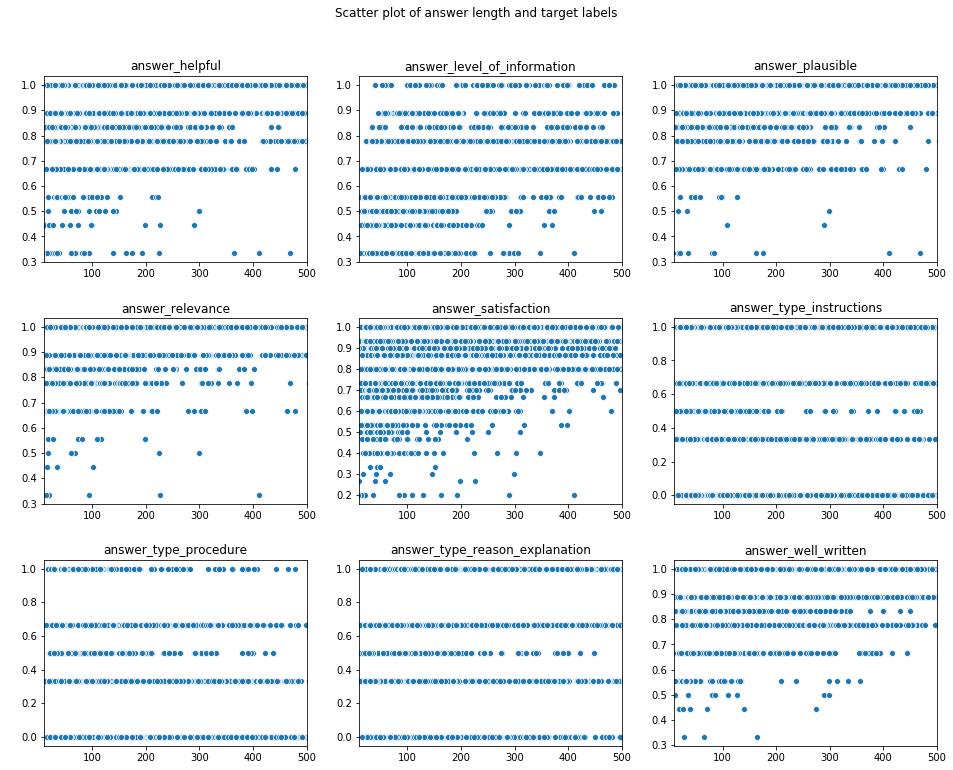

In [108]:
#Checking the relationship of question length with question related labels
grid = gridspec.GridSpec(3,3)

plt.figure(figsize=(16,12))
count=0
target_cols = train[a_target_cols]
plt.suptitle('Scatter plot of answer length and target labels')
for n, col in enumerate(target_cols):
    ax = plt.subplot(grid[count])
    sns.scatterplot(x=train.answer_n_words, y=train[col])
    ax.set_title(str(col))
    ax.set_xlim(left=10, right=500)
    ax.set_xlabel('')
    ax.set_ylabel(' ')
    count+=1
    #ax.set_xticklabels(sorted(train.question_n_words.unique()),rotation=45)

plt.subplots_adjust(top = 0.9, hspace=.3, wspace=.2)
plt.show()

Question and answer lengths do not seem to have much effect on any of the target label ratings.

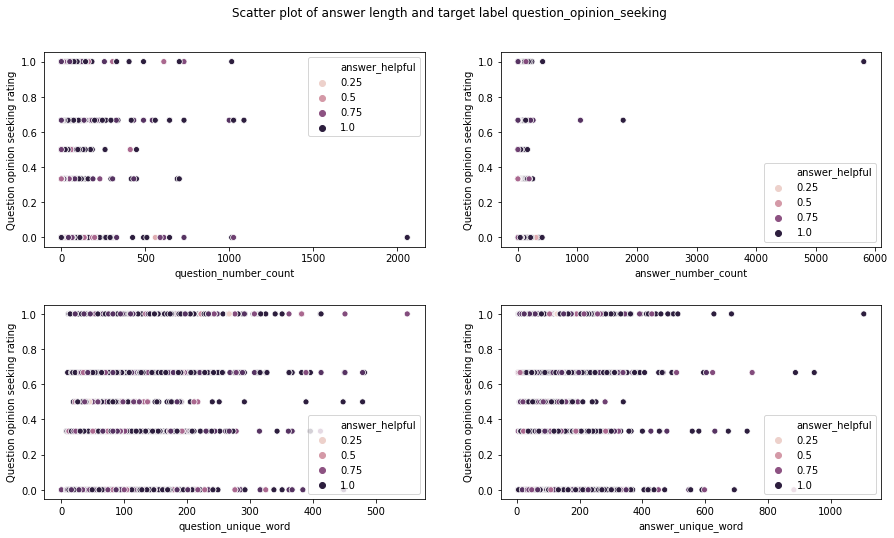

In [9]:
train['question_number_count'] = train.question_body.apply(lambda x:sum(c.isdigit() for c in x))
train['answer_number_count'] = train.answer.apply(lambda x:sum(c.isdigit() for c in x))
train['question_unique_word']=train["question_body"].apply(lambda x: len(set(str(x).split())))
train['answer_unique_word']=train.answer.apply(lambda x: len(set(str(x).split())))

columns  = ['question_number_count', 'answer_number_count', 'question_unique_word', 'answer_unique_word']

#Checking the relationship of question length with question related labels
grid = gridspec.GridSpec(2,2)

plt.figure(figsize=(15,8))
count=0
target_cols = train[columns]
plt.suptitle('Scatter plot of answer length and target label question_opinion_seeking')
for n, col in enumerate(target_cols):
    ax = plt.subplot(grid[count])
    sns.scatterplot(x=train[col], y=train.question_opinion_seeking, hue = train.answer_helpful)
    ax.set_xlabel(str(col))
    ax.set_ylabel('Question opinion seeking rating')
    count+=1
    #ax.set_xticklabels(sorted(train.question_n_words.unique()),rotation=45)

plt.subplots_adjust(top = 0.9, hspace=.3, wspace=.2)
plt.show()

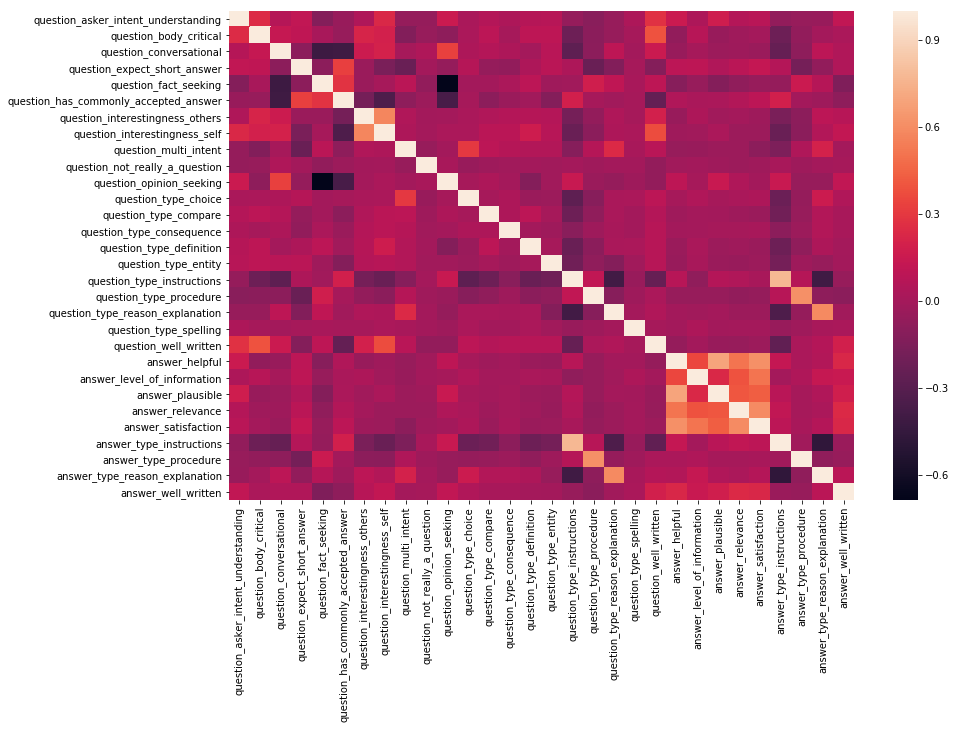

In [9]:
columns  = ['question_n_words', 'answer_n_words','questitle_n_words', 'question_number_count',
            'answer_number_count', 'question_unique_word', 'answer_unique_word']
plt.figure(figsize = (14,9))
sns.heatmap(train[q_target_cols+a_target_cols].corr())
plt.show()

There is minimal correlation between the target variables and the independent variables.

<Figure size 720x432 with 0 Axes>

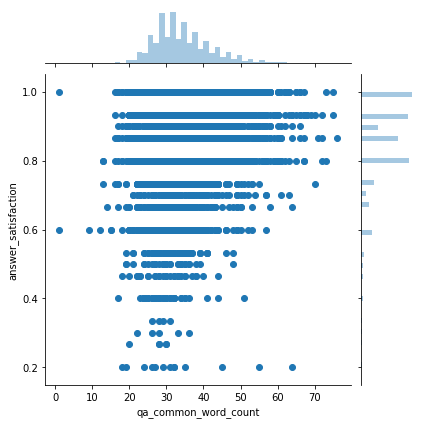

<Figure size 720x432 with 0 Axes>

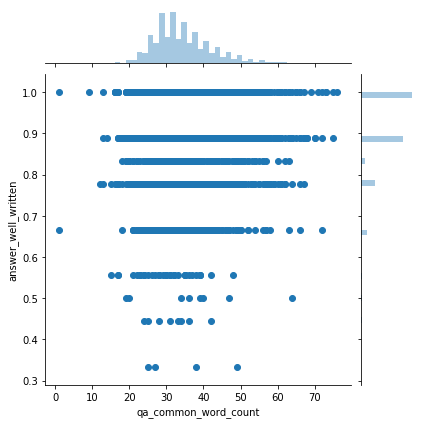

In [45]:
def get_common_words_count(text):
    return len(set(text[0])&set(text[1]))

def get_common_words_frac(text):
    return len(set(text[0])&set(text[1]))/len(set(text[0])|set(text[1]))
    
train['qa_common_word_count'] = train[['question_body', 'answer']].apply(get_common_words_count, axis =1)
train['qa_common_word_frac'] = train[['question_body', 'answer']].apply(get_common_words_frac, axis =1)


#Checking the relationship of question and answer commonn word length with answer satisfaction
plt.figure(figsize=(10,6))
sns.jointplot(x=train.qa_common_word_count, y=train.answer_satisfaction)
plt.show()

#Checking the relationship of question and answer commonn word percent with answer well written
plt.figure(figsize=(10,6))
sns.jointplot(x=train.qa_common_word_count, y=train.answer_well_written)
plt.show()

Slightly higher level of answer satisfaction can be observed when there are more common words between queston and answer. If high percentage of words between question and answers are common then the answer has been deemed to be written well.

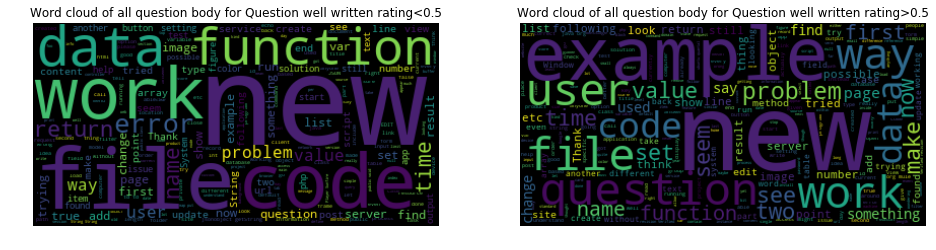

In [47]:
stopwords = set(STOPWORDS)
## Word cloud of question bodies##
stopwords.update(["gt", "lt", "amp", "nbsp", "one", "use", "will","using", "would","need", "want", "know"])
text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.question_well_written<0.5]['question_body'])
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,
                        max_words=250,
                        random_state=42).generate(text)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word cloud of all question body for Question well written rating<0.5')


text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.question_well_written>=0.5]['question_body'])

wordcloud = WordCloud(stopwords=stopwords,
                        max_words=250,
                        random_state=42).generate(text)
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word cloud of all question body for Question well written rating>0.5')

plt.show()

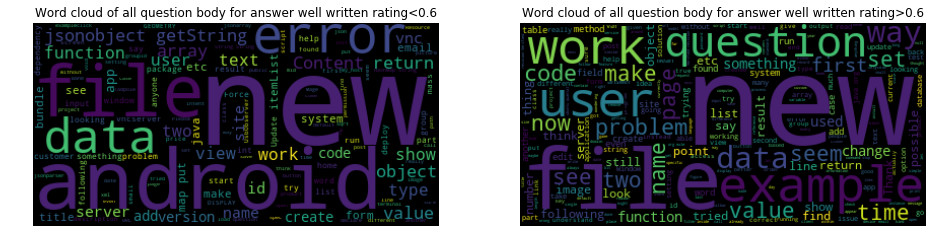

In [48]:
stopwords = set(STOPWORDS)
## Word cloud of answer##
stopwords.update(["gt", "lt", "amp", "nbsp", "one", "use", "will","using", "would","need", "want", "know"])
text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.answer_well_written<0.6]['question_body'])
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, 
                        max_words=250,
                        random_state=42).generate(text)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word cloud of all question body for answer well written rating<0.6')


text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.answer_well_written>=0.6]['question_body'])

wordcloud = WordCloud(stopwords=stopwords,
                        max_words=250,
                        random_state=42).generate(text)
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word cloud of all question body for answer well written rating>0.6')

plt.show()

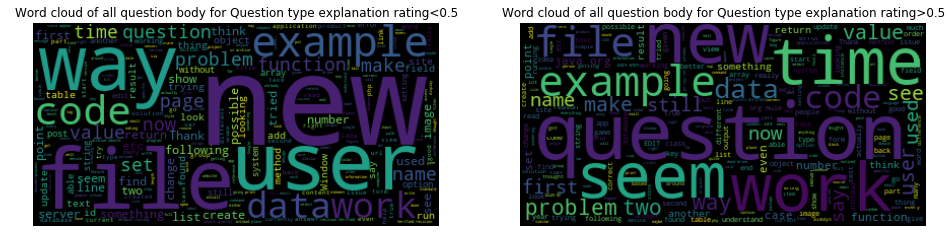

In [49]:
stopwords = set(STOPWORDS)
## Word cloud of question bodies##
stopwords.update(["gt", "lt", "amp", "nbsp", "one", "use", "will","using", "would","need", "want", "know"])
text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.question_type_reason_explanation<0.5]['question_body'])
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,
                        max_words=250,
                        random_state=42).generate(text)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word cloud of all question body for Question type explanation rating<0.5')


text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.question_type_reason_explanation>=0.5]['question_body'])

wordcloud = WordCloud(stopwords=stopwords,
                        max_words=250,
                        random_state=42).generate(text)
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word cloud of all question body for Question type explanation rating>0.5')

plt.show()

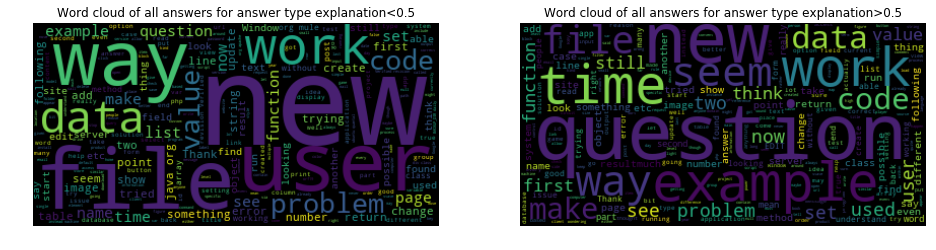

In [59]:
stopwords = set(STOPWORDS)
## Word cloud of answer##
stopwords.update(["gt", "lt", "amp", "nbsp", "one", "use", "will","using", "would","need", "want", "know"])
text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.answer_type_reason_explanation<0.5]['question_body'])
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,
                        max_words=250,
                        random_state=42).generate(text)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word cloud of all answers for answer type explanation<0.5')


text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.answer_type_reason_explanation>=0.5]['question_body'])

wordcloud = WordCloud(stopwords=stopwords,
                        max_words=250,
                        random_state=42).generate(text)
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word cloud of all answers for answer type explanation>0.5')

plt.show()

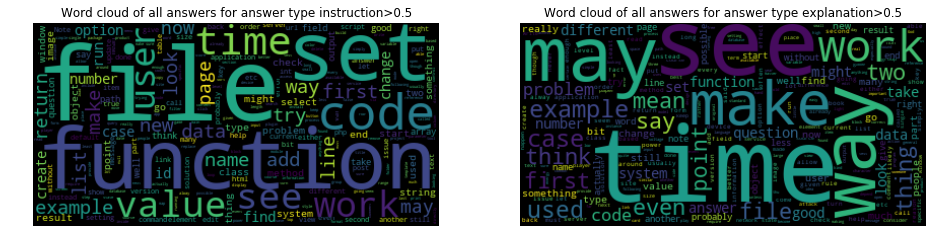

In [11]:
stopwords = set(STOPWORDS)
## Word cloud of answer##
stopwords.update(["gt", "lt", "amp", "nbsp", "one", "use", "will","using", "would","need", "want", "know"])
text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.answer_type_instructions>0.5]['answer'])
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,
                        max_words=250,
                        random_state=42).generate(text)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word cloud of all answers for answer type instruction>0.5')


text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.answer_type_reason_explanation>0.5]['answer'])

wordcloud = WordCloud(stopwords=stopwords,
                        max_words=250,
                        random_state=42).generate(text)
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word cloud of all answers for answer type explanation>0.5')

plt.show()

We have seen from earlier that instruction type answer ratings and explanation type answer ratings are negatively correlated. As opposed to instruction type answers which have more computer related words, the answers which are of explanation type have higher frequency of generic words.

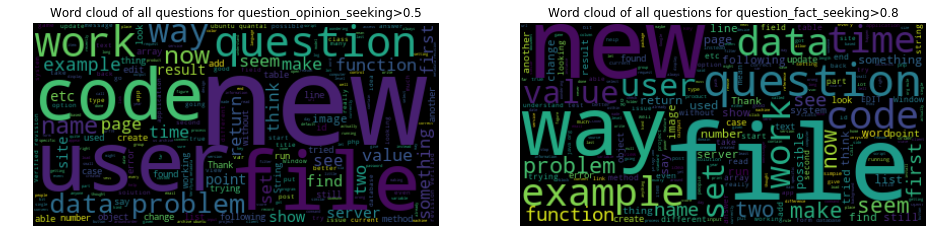

In [14]:
stopwords = set(STOPWORDS)
## Word cloud of answer##
stopwords.update(["gt", "lt", "amp", "nbsp", "one", "use", "will","using", "would","need", "want", "know"])
text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.question_opinion_seeking>0.5]['question_body'])
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,
                        max_words=250,
                        random_state=42).generate(text)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word cloud of all questions for question_opinion_seeking>0.5')


text = ' '.join(BeautifulSoup(txt).get_text() for txt in train[train.question_fact_seeking>0.8]['question_body'])

wordcloud = WordCloud(stopwords=stopwords,
                        max_words=250,
                        random_state=42).generate(text)
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word cloud of all questions for question_fact_seeking>0.8')

plt.show()

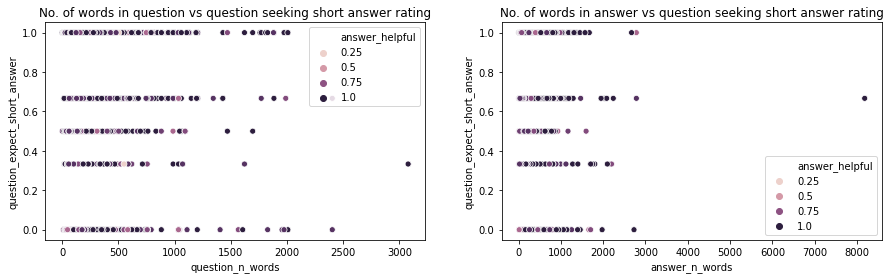

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize = (15, 4))
sns.scatterplot(x = train.question_n_words, y= train.question_expect_short_answer, ax= ax1, hue=train.answer_helpful)
sns.scatterplot(x = train.answer_n_words, y = train.question_expect_short_answer, ax= ax2, hue=train.answer_helpful)
ax1.set_title('No. of words in question vs question seeking short answer rating')
ax2.set_title('No. of words in answer vs question seeking short answer rating')
plt.show()

1. For questions seeking short answers, the question length need not be small as can be seen from the first plot.
2. The answer length for questions seeking short answers are also not really short. It can be observed from the second plot that longer answers to those questions have also been helpful.

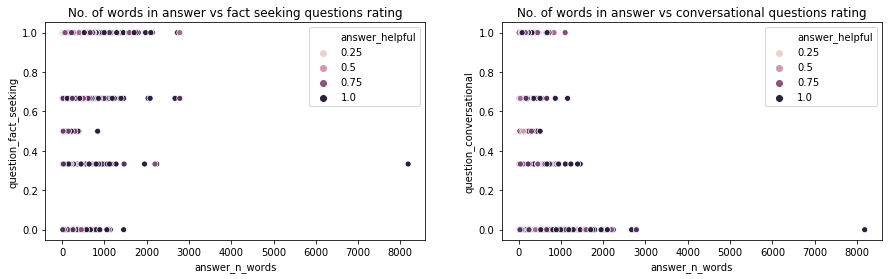

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize = (15, 4))
sns.scatterplot(x = train.answer_n_words, y= train.question_fact_seeking, ax= ax1, hue=train.answer_helpful)
sns.scatterplot(x = train.answer_n_words, y = train.question_conversational, ax= ax2, hue=train.answer_helpful)
ax1.set_title('No. of words in answer vs fact seeking question rating')
ax2.set_title('No. of words in answer vs conversational question rating')
plt.show()

More conversational questions are expected to have longer answers. But we can see from the plots that fact seeking questions have longer answers than conversational ones which is surprising. But it can be observed that smaller answers to conversational questions are less heplful.

<h2>EDA Takeaways</h2>

1. There is missing values problem in the dataset. There are 41 features in total which includes 30 target labels.
2. Number of unique users who asked questions are 3422 and number of unique users who answered questions are 4430. Mostly users have asked 1-2 questions but there are a few outliers. 
3. In this data maximum questions belong to Technology and Stackoverflow category. At host level also the Stackoverflow has considerably more number of questions than any other host category.
4. A sequence length of 1000 for question body and answer will be good enough. For question title sequence length will cover most of the datapoints.
5. The words in the word cloud for each category reveals the most frequently used words in that field. For example code, function, return, value. etc are the most frequently words in category stackoverflow. Similarly for other categories the most frequent words makes sense. The case is same for the host category level wordclouds.
6. Both the questions and answer have similar polarity distributions. Questions and answers are mostly neutral because the websites from which they have been collected are mostly technical in nature, i.e., users do not show much emotion while asking questions or answering.
7. Some of the labels like question type definition question type consequence, question conversational, etc. in general have very low rating barring a few outliers. Question askers intent understanding and question interestingness others have smallest range of values. Most of the answers are well written and are heplful,satisfactory and plausible as indicated by very high median values.
8. The 'category' feature could be an important feature in determining the ratings for these labels: 
    - 'answer_type_reason_explanation'
    - 'answer_type_instructions'
    - 'question_well_written'
    - 'question_type_instruction'
    - 'question_interestingness_self'
    - 'question_body_critical'
9. Answer helpful, level of information, plausible, relevance and satisfaction has some level of correlation amongst them.
10. Question and answer lengths do not seem to have much effect on any of the target label ratings.
11. Slightly higher level of answer satisfaction can be observed when there are more common words between queston and answer. If high percentage of words between question and answers are common then the answer has been deemed to be written well.
12. The two feaures instruction type answer ratings and explanation type answer ratings are negatively correlated. As opposed to instruction type answers which have more computer related words, the answers which are of explanation type have higher frequency of generic words.
13. More conversational questions are expected to have longer answers. But it can be observed that  fact seeking questions have longer answers than conversational ones which is surprising. But it can be observed that smaller answers to conversational questions are less heplful.